In [13]:
import numpy as np
import scanpy as sc
import scvi
import scanorama
import pyliger
from harmony import harmonize
from scib_metrics.benchmark import Benchmarker
import celltypist
from celltypist import models
import scib
import bbknn

import collections 
import sys
if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    from collections.abc import MutableSet
    collections.MutableSet = collections.abc.MutableSet
else: 
    from collections import MutableSet

# R interface
import scanpy as sc
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
# For Seurat-based integration
%%R
library(Seurat)

In [2]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=700,
    vector_friendly=False,
    facecolor="white",
    frameon=False,
)

In [ ]:
adata = sc.read("/mnt/sdb/qdang/singlecell/human/naive/fullgene_hvg_foetal_integrated.h5ad")

In [5]:
# Perform scVI integration

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="Batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 84/84: 100%|████████████████| 84/84 [18:48<00:00, 13.41s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.81e+3]

`Trainer.fit` stopped: `max_epochs=84` reached.


Epoch 84/84: 100%|████████████████| 84/84 [18:48<00:00, 13.44s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.81e+3]


In [8]:
# Perform automated cell type annotation to assist label-aware integration methods
#For the query, counts are normalized to 10,000 counts per cell, then log1p-transformed
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [9]:
# Perform cell type annotation
predictions = celltypist.annotate(adata_celltypist, model = '/mnt/sdb/qdang/singlecell/human/naive/foetal_model_from_kundaje.pkl', majority_voting = True)

🔬 Input data has 95189 cells and 6000 genes
🔗 Matching reference genes in the model
🧬 1753 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


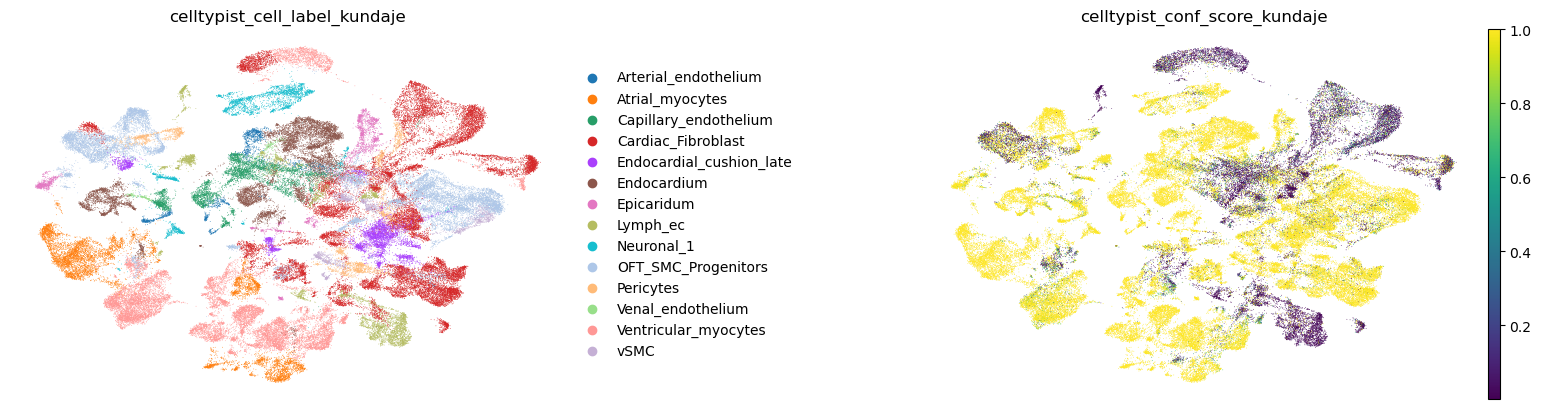

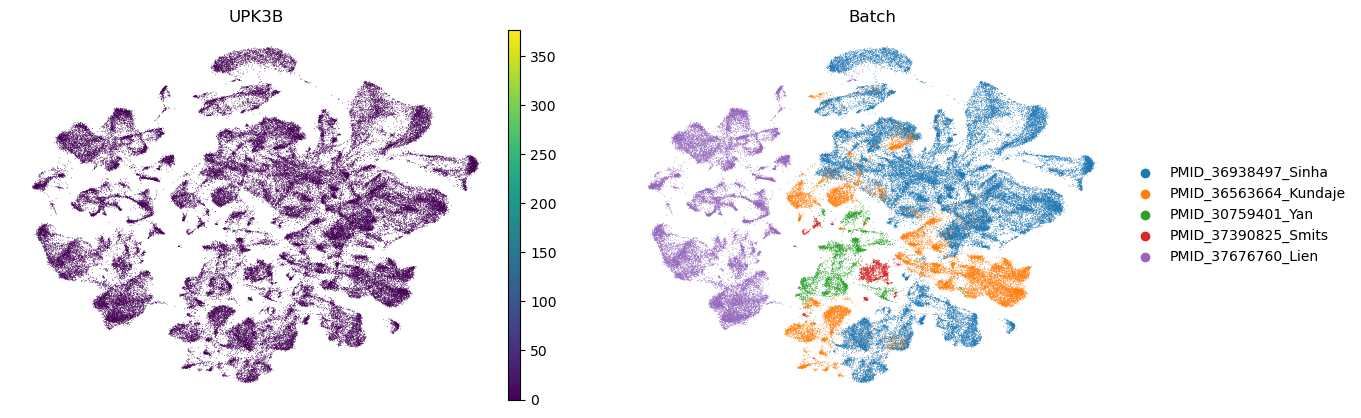

In [12]:
predictions_adata = predictions.to_adata()
adata.obs["celltypist_cell_label_kundaje"] = predictions_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_kundaje"] = predictions_adata.obs.loc[
    adata.obs.index, "conf_score"
]
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_kundaje", "celltypist_conf_score_kundaje"],
    frameon=False,
    sort_order=False,
    wspace=0.5,
)
sc.pl.umap(
    adata,
    color=["UPK3B",'Batch'],
    frameon=False,
    sort_order=False,
)

In [13]:
# Perform scANVi integration
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="celltypist_cell_label_kundaje",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|█████████████████| 20/20 [09:34<00:00, 28.77s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.9e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█████████████████| 20/20 [09:34<00:00, 28.72s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.9e+3]


In [27]:
label_key = 'celltypist_cell_label_kundaje'
batch_key = 'Batch'

In [29]:
# Runn BBKNN integration. Select the number of neighbors per batch for K-nearest neighbor graph
neighbors_within_batch = 25 if adata.n_obs > 100000 else 3
neighbors_within_batch

3

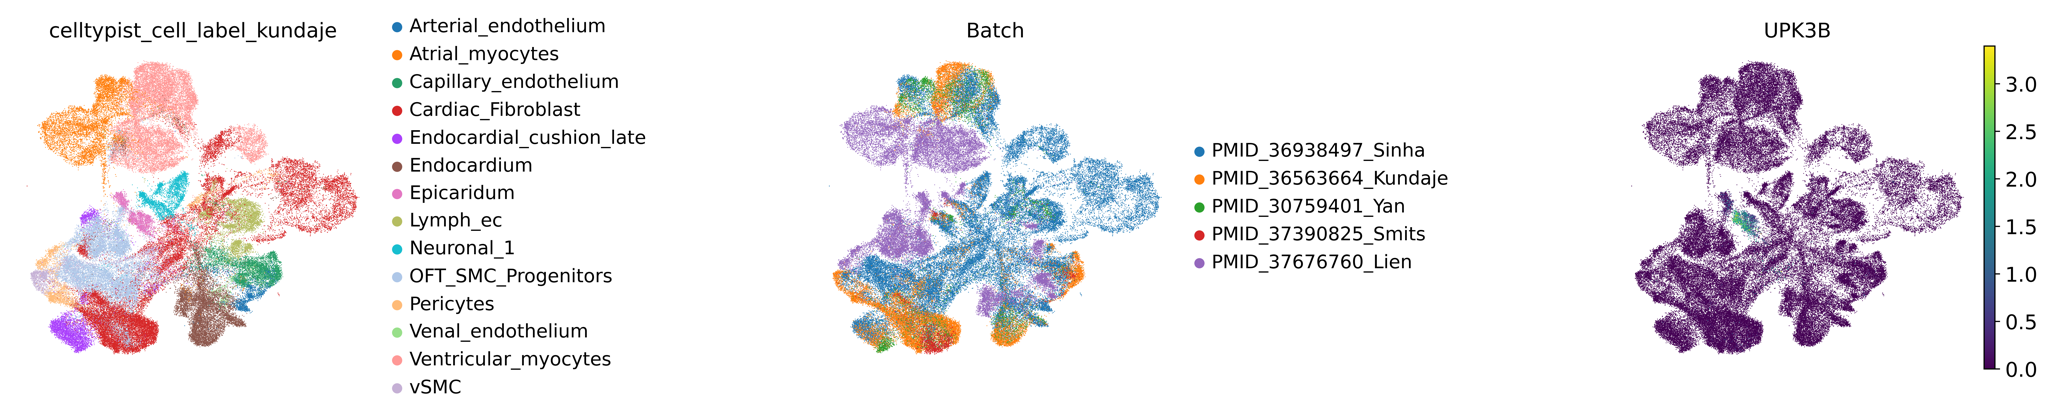

In [37]:
adata.X = adata.layers["log1p_norm"].copy()
sc.pp.pca(adata)
bbknn.bbknn(
    adata, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
sc.tl.umap(adata)
sc.pl.umap(adata, color=[label_key, batch_key,'UPK3B'], wspace=1, layer='log1p_norm')

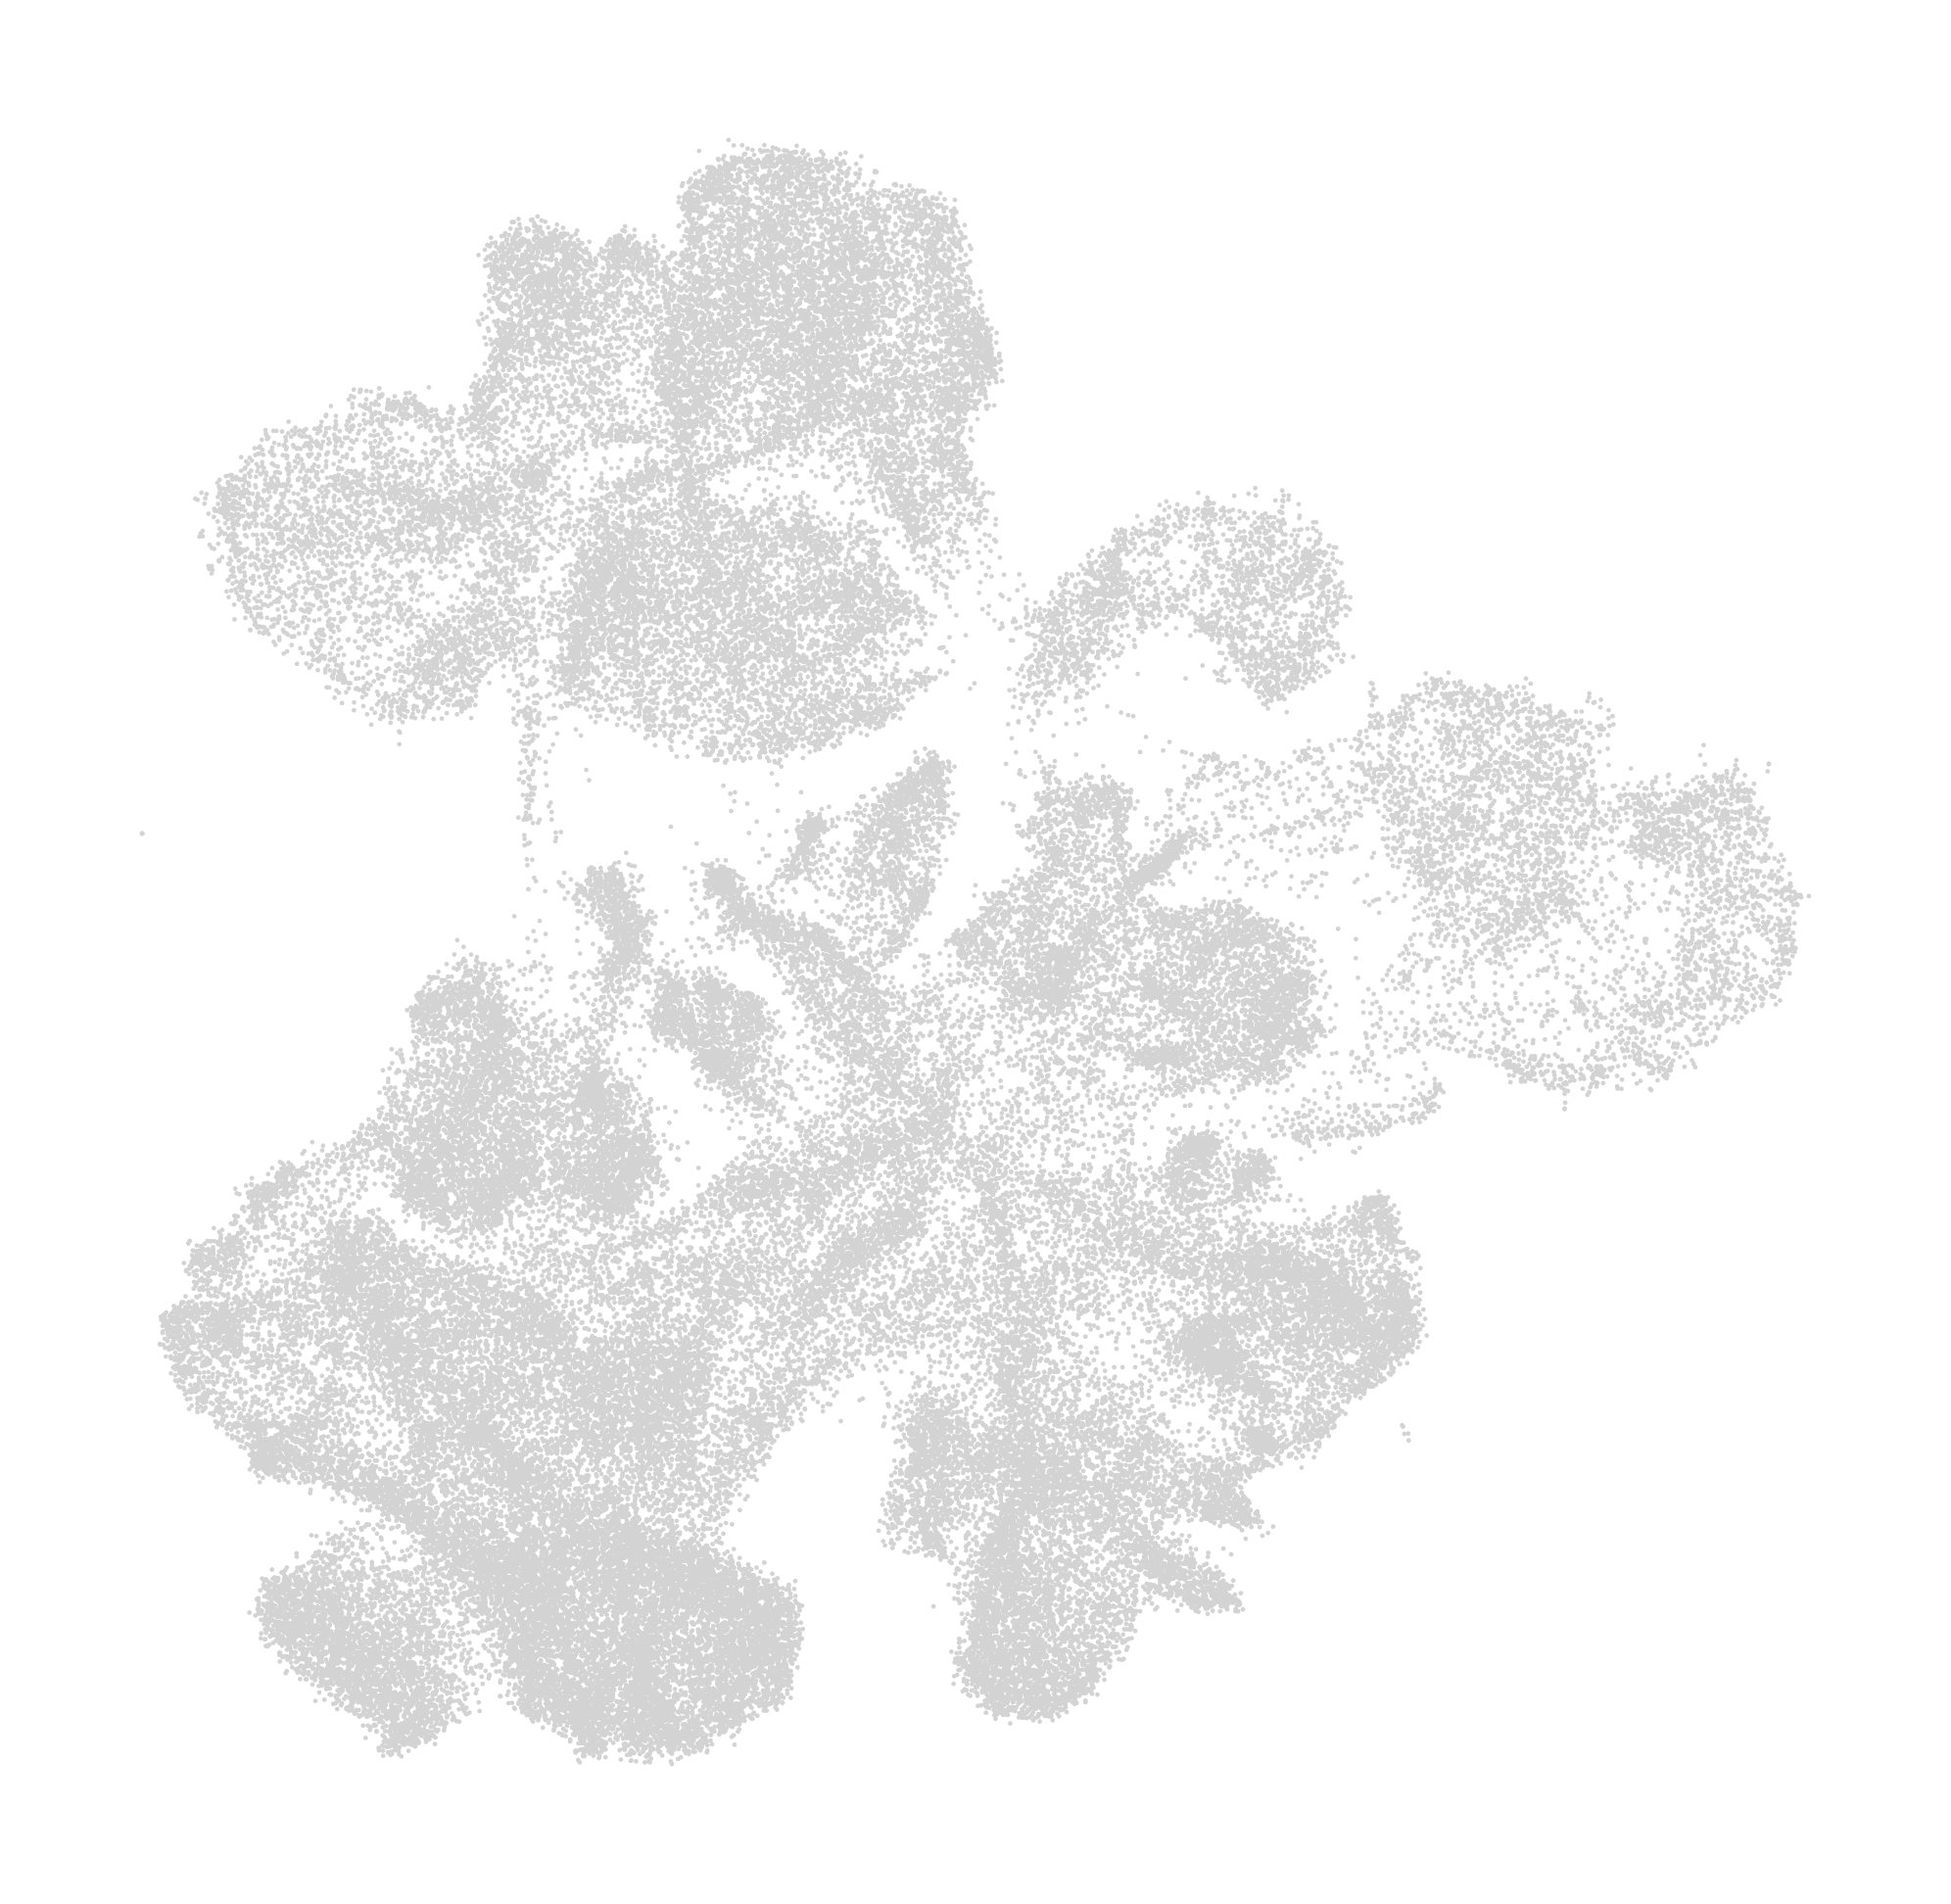

In [39]:
adata.obsm['BBKNN'] = adata.obsm['X_umap'].copy()
sc.pl.embedding(adata, basis='BBKNN')

In [3]:
# Run scGen integration
model = scib.integration.scgen(adata, batch='Batch', cell_type='celltypist_cell_label_kundaje')

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/pkg_resources/__init__.py:2348: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit names

Epoch 2/100:   1%|▏                     | 1/100 [01:08<1:53:09, 68.58s/it, v_num=1, train_loss_step=204, train_loss_epoch=184]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 3/100:   2%|▍                     | 2/100 [02:15<1:50:05, 67.40s/it, v_num=1, train_loss_step=201, train_loss_epoch=156]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 4/100:   3%|▋                     | 3/100 [03:21<1:48:21, 67.03s/it, v_num=1, train_loss_step=236, train_loss_epoch=151]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 5/100:   4%|▉                     | 4/100 [04:28<1:46:59, 66.87s/it, v_num=1, train_loss_step=149, train_loss_epoch=149]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 6/100:   5%|█                     | 5/100 [05:34<1:45:43, 66.78s/it, v_num=1, train_loss_step=457, train_loss_epoch=147]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 7/100:   6%|█▎                    | 6/100 [06:41<1:44:30, 66.70s/it, v_num=1, train_loss_step=172, train_loss_epoch=146]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 8/100:   7%|█▌                    | 7/100 [07:48<1:43:21, 66.69s/it, v_num=1, train_loss_step=372, train_loss_epoch=145]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 9/100:   8%|█▊                    | 8/100 [08:54<1:42:09, 66.62s/it, v_num=1, train_loss_step=101, train_loss_epoch=145]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 10/100:   9%|█▉                   | 9/100 [10:01<1:41:03, 66.63s/it, v_num=1, train_loss_step=189, train_loss_epoch=144]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 11/100:  10%|██                  | 10/100 [11:07<1:39:53, 66.60s/it, v_num=1, train_loss_step=207, train_loss_epoch=144]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 12/100:  11%|██▏                 | 11/100 [12:14<1:38:46, 66.59s/it, v_num=1, train_loss_step=180, train_loss_epoch=143]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 13/100:  12%|██▍                 | 12/100 [13:21<1:37:39, 66.58s/it, v_num=1, train_loss_step=182, train_loss_epoch=143]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 14/100:  13%|██▌                 | 13/100 [14:27<1:36:34, 66.60s/it, v_num=1, train_loss_step=140, train_loss_epoch=142]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 15/100:  14%|██▊                 | 14/100 [15:34<1:35:33, 66.67s/it, v_num=1, train_loss_step=141, train_loss_epoch=142]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 16/100:  15%|███                 | 15/100 [16:40<1:34:22, 66.61s/it, v_num=1, train_loss_step=158, train_loss_epoch=142]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 17/100:  16%|███▏                | 16/100 [17:47<1:33:19, 66.66s/it, v_num=1, train_loss_step=303, train_loss_epoch=142]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 18/100:  17%|███▍                | 17/100 [18:54<1:32:16, 66.71s/it, v_num=1, train_loss_step=164, train_loss_epoch=142]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 19/100:  18%|███▌                | 18/100 [20:01<1:31:09, 66.71s/it, v_num=1, train_loss_step=194, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 20/100:  19%|███▊                | 19/100 [21:07<1:30:00, 66.67s/it, v_num=1, train_loss_step=611, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 21/100:  20%|████                | 20/100 [22:14<1:28:42, 66.53s/it, v_num=1, train_loss_step=154, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 22/100:  21%|████▏               | 21/100 [23:19<1:27:03, 66.12s/it, v_num=1, train_loss_step=719, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 23/100:  22%|████▍               | 22/100 [24:25<1:26:05, 66.23s/it, v_num=1, train_loss_step=178, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 24/100:  23%|████▌               | 23/100 [25:32<1:25:04, 66.29s/it, v_num=1, train_loss_step=723, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 25/100:  24%|████▊               | 24/100 [26:38<1:24:07, 66.41s/it, v_num=1, train_loss_step=190, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 26/100:  25%|█████               | 25/100 [27:45<1:23:05, 66.47s/it, v_num=1, train_loss_step=183, train_loss_epoch=141]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 26/100:  26%|█████▏              | 26/100 [28:52<1:22:09, 66.62s/it, v_num=1, train_loss_step=165, train_loss_epoch=140]

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)



Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1128.600. Signaling Trainer to stop.


/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


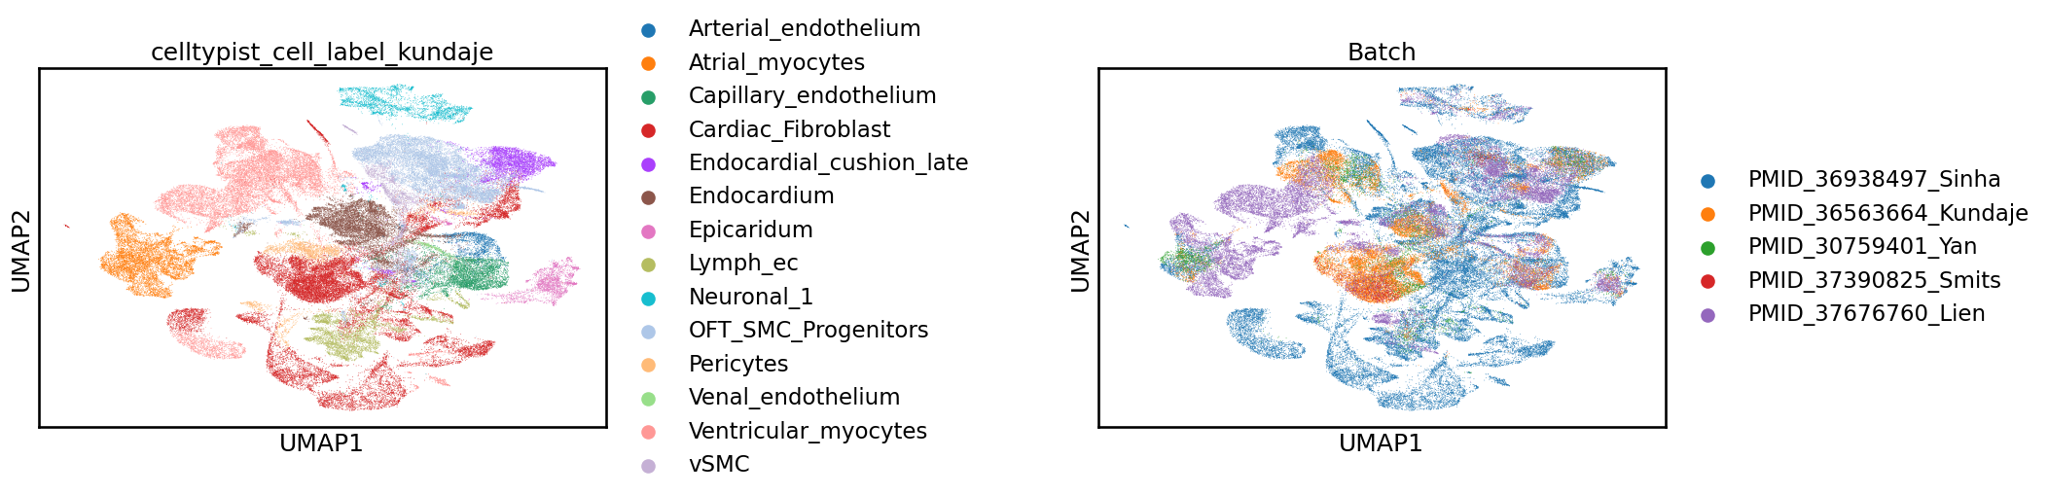

In [21]:
# Copy over the scGen-corrected counts, build a new neighborhood graph based on scGen latent embedding, and perform UMAP
adata.obsm['scGen'] = model.obsm['latent']
adata.layers['scGen_corrected'] = model.X.copy()
adata.X = adata.layers['scGen_corrected'].copy()
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['celltypist_cell_label_kundaje', 'Batch'], wspace=0.7)

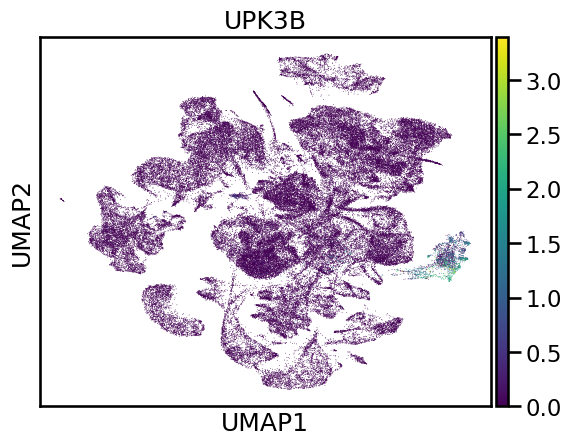

In [22]:
# Visualise how well the integration took place for epicardial cells
sc.pl.umap(adata, color=['UPK3B'], layer='log1p_norm')

/mnt/sdb/qdang/micromamba/envs/scib/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


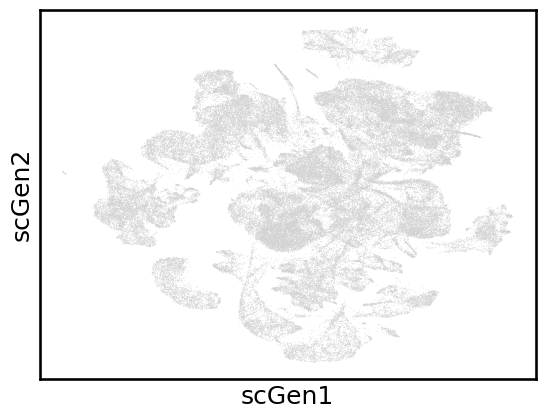

In [25]:
adata.obsm['scGen'] = adata.obsm['X_umap'].copy()
sc.pl.embedding(adata, basis='scGen')

In [5]:
# Run Seurat integration
adata_seurat = adata
# Convert categorical columns to strings
adata_seurat.obs[batch_key] = adata_seurat.obs[batch_key].astype(str)
adata_seurat.obs[label_key] = adata_seurat.obs[label_key].astype(str)
# Delete uns as this can contain arbitrary objects which are difficult to convert
del adata_seurat.uns
adata_seurat

AnnData object with n_obs × n_vars = 95189 × 6000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'BBKNN', 'X_pca', 'X_umap', 'scANVI', 'scGen', 'scVI'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', 'scGen_corrected'
    obsp: 'connectivities', 'distances'

In [8]:
# Transfer the anndata object into R. The object is converted into a SingleCellexperiment object. 
%%R -i adata_seurat
adata_seurat

class: SingleCellExperiment 
dim: 6000 95189 
metadata(0):
assays(4): X counts log1p_norm scGen_corrected
rownames(6000): A1BG A1BG-AS1 ... ZSWIM6 ZWINT
rowData names(7): n_cells highly_variable ... highly_variable_nbatches
  highly_variable_intersection
colnames(95189): AAACCCAGTCAAAGTA-1 AAACCCAGTCACTTAG-1 ...
  TTTGTTGGTTGTCCAT-1 TTTGTTGGTTTGAGGC-1
colData names(28): n_genes_by_counts log1p_n_genes_by_counts ...
  celltypist_cell_label_kundaje celltypist_conf_score_kundaje
reducedDimNames(6): BBKNN PCA ... scGen scVI
mainExpName: NULL
altExpNames(0):


In [9]:
# Convert the SingleCellexperiment object into a Seurat object
%%R -i adata_seurat
seurat <- as.Seurat(adata_seurat, counts = "counts", data = "log1p_norm")
seurat

An object of class Seurat 
6000 features across 95189 samples within 1 assay 
Active assay: originalexp (6000 features, 0 variable features)
 2 layers present: counts, data
 6 dimensional reductions calculated: BBKNN, PCA, UMAP, scANVI, scGen, scVI


In [10]:
# Split the seurat object into individual objects representing batches
%%R -i batch_key
batch_list <- SplitObject(seurat, split.by = batch_key)
batch_list

$PMID_36938497_Sinha
An object of class Seurat 
6000 features across 49460 samples within 1 assay 
Active assay: originalexp (6000 features, 0 variable features)
 2 layers present: counts, data
 6 dimensional reductions calculated: BBKNN, PCA, UMAP, scANVI, scGen, scVI

$PMID_36563664_Kundaje
An object of class Seurat 
6000 features across 17617 samples within 1 assay 
Active assay: originalexp (6000 features, 0 variable features)
 2 layers present: counts, data
 6 dimensional reductions calculated: BBKNN, PCA, UMAP, scANVI, scGen, scVI

$PMID_30759401_Yan
An object of class Seurat 
6000 features across 4452 samples within 1 assay 
Active assay: originalexp (6000 features, 0 variable features)
 2 layers present: counts, data
 6 dimensional reductions calculated: BBKNN, PCA, UMAP, scANVI, scGen, scVI

$PMID_37390825_Smits
An object of class Seurat 
6000 features across 1720 samples within 1 assay 
Active assay: originalexp (6000 features, 0 variable features)
 2 layers present: counts, 

In [11]:
# Define integration anchors for each pair of datasets. Use highly variable features
%%R
anchors <- FindIntegrationAnchors(batch_list, anchor.features = rownames(seurat))
anchors

  |                                                  | 0 % ~calculating   |++++++++++                                        | 20% ~30s           |++++++++++++++++++++                              | 40% ~15s           |++++++++++++++++++++++++++++++                    | 60% ~07s           |++++++++++++++++++++++++++++++++++++++++          | 80% ~03s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=16s  
  |                                                  | 0 % ~calculating   |+++++                                             | 10% ~02h 49m 25s   |++++++++++                                        | 20% ~01h 50m 15s   |+++++++++++++++                                   | 30% ~01h 11m 04s   |++++++++++++++++++++                              | 40% ~53m 27s       |+++++++++++++++++++++++++                         | 50% ~37m 25s       |++++++++++++++++++++++++++++++                    | 60% ~25m 12s       |+++++++++++++++++++++++++++++++++++               | 70% ~23

Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 29511 anchors
Filtering anchors
	Retained 10898 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 13225 anchors
Filtering anchors
	Retained 8630 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 12077 anchors
Filtering anchors
	Retained 7921 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 7323 anchors
Filtering anchors
	Retained 4120 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 6966 anchors
Filtering anchors
	Retained 4831 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4705 anchors
Filtering anchors
	Retained 2998 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 29747 anchors
Filtering anchors
	Retained 9256 anchors
Running CCA
Merging objects
Finding nei

In [12]:
# compute a transformation that maps one dataset onto another
%%R
integrated <- IntegrateData(anchors)
integrated

An object of class Seurat 
12000 features across 95189 samples within 2 assays 
Active assay: integrated (6000 features, 6000 variable features)
 1 layer present: data
 1 other assay present: originalexp


Merging dataset 4 into 2
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 3 into 1
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 2 4 into 1 3
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 5 into 1 3 2 4
Extracting anchors for merged samples
Finding integration v

In [13]:
# Extract the corrected expression matrix in which datasets have been integrated 
%%R -o integrated_expr
# Extract the integrated expression matrix
integrated_expr <- GetAssayData(integrated)
# Make sure the rows and columns are in the same order as the original object
integrated_expr <- integrated_expr[rownames(seurat), colnames(seurat)]
# Transpose the matrix to AnnData format
integrated_expr <- t(integrated_expr)
print(integrated_expr[1:10, 1:10])

10 x 10 sparse Matrix of class "dgCMatrix"
                                                                     
AAACCCAGTCAAAGTA-1 .        . . .         . 1.4622003 . . .         .
AAACCCAGTCACTTAG-1 .        . . .         . .         . . .         .
AAACGAAAGGTTGACG-1 .        . . .         . .         . . .         .
AAACGAACAGCTGTCG-1 .        . . .         . .         . . .         .
AAACGAATCAAGTGTC-1 .        . . .         . .         . . .         .
AAACGAATCGCCAATA-1 .        . . 1.5030398 . .         . . 0.2381282 .
AAACGCTAGCAGCACA-1 .        . . 1.8931519 . 0.3603747 . . .         .
AAACGCTAGCCGTTAT-1 .        . . 0.8479836 . .         . . 0.3680941 .
AAACGCTCACAATGTC-1 0.267278 . . .         . .         . . .         .
AAACGCTCATGCCGGT-1 .        . . .         . .         . . .         .


  [[ suppressing 10 column names 'A1BG', 'A1BG-AS1', 'A1CF' ... ]]


In [14]:
# store the corrected expression matrix as a layer in our AnnData object. Set this matrix to the .X layer
adata_seurat.X = integrated_expr
adata_seurat.layers["seurat"] = integrated_expr
print(adata_seurat)

AnnData object with n_obs × n_vars = 95189 × 6000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'BBKNN', 'X_pca', 'X_umap', 'scANVI', 'scGen', 'scVI'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', 'scGen_corrected', 'seurat'
    obsp: 'connectivities', 'distances'


2024-10-08 07:53:15.050286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 07:53:15.320885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 07:53:15.320926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 07:53:15.334923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 07:53:15.356302: I tensorflow/core/platform/cpu_feature_guar

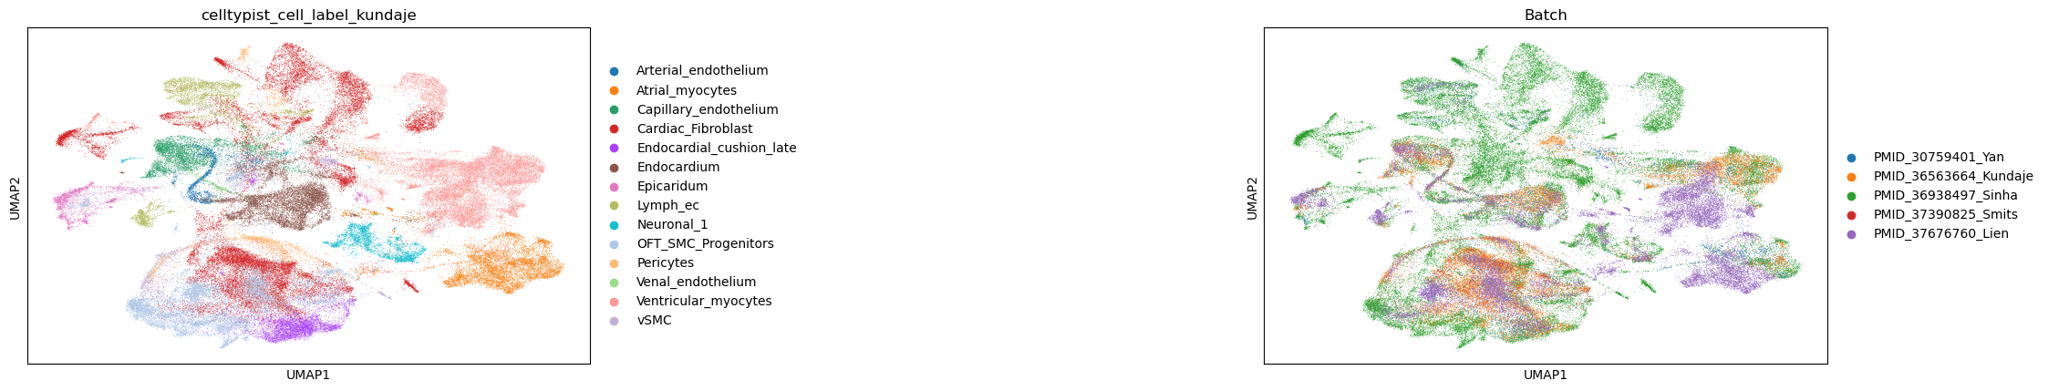

In [16]:
# Use this corrected count from Seurat to perform PCA and UMAP
sc.tl.pca(adata_seurat)
sc.pp.neighbors(adata_seurat)
sc.tl.umap(adata_seurat)
sc.pl.umap(adata_seurat, color=[label_key, batch_key], wspace=1)

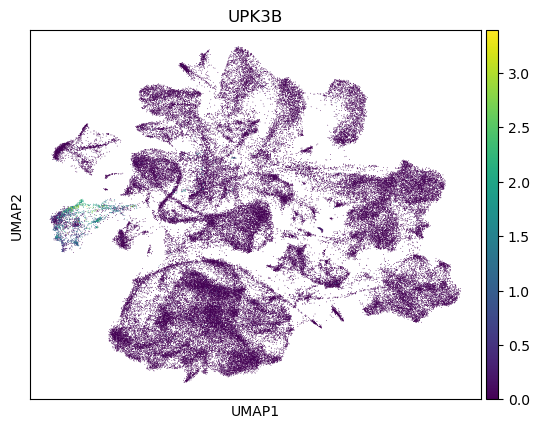

In [18]:
# Visualise the integration for epicardial cells
sc.pl.umap(adata_seurat, color=['UPK3B'], wspace=1, layer='log1p_norm')

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


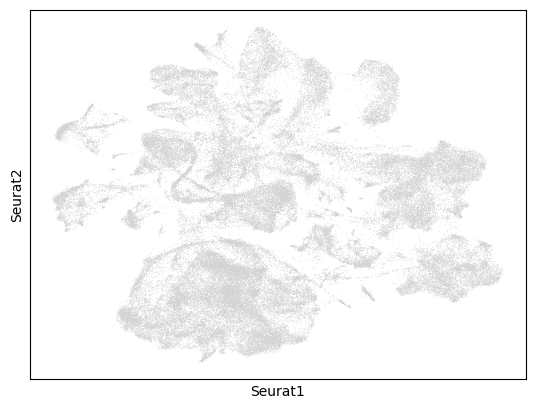

In [21]:
adata_seurat.obsm['Seurat'] = adata_seurat.obsm['X_umap'].copy()
sc.pl.embedding(adata_seurat, basis='Seurat')

In [8]:
# Perform scanorama integration

# List of adata per batch
batch_cats = adata.obs['Batch'].unique()
adata_list = [adata[adata.obs['Batch'] == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs['Batch'] == b] = adata_list[i].obsm["X_scanorama"]

Found 6000 genes among all datasets
[[0.         0.57609128 0.52493261 0.23546512 0.01107966]
 [0.         0.         0.61006289 0.21511628 0.01877849]
 [0.         0.         0.         0.13837209 0.03077269]
 [0.         0.         0.         0.         0.04127907]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 3)
Processing datasets (2, 3)


In [9]:
# perform LIGER integration

batch_cats = adata.obs['Batch'].unique()
adata_list = [adata[adata.obs['Batch'] == b].copy() for b in batch_cats]
bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs['Batch'] == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs['Batch'] == b] = liger_data.adata_list[i].obsm["H_norm"]

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/pyliger/preprocessing/_scale.py:99: RuntimeWarning: divide by zero encountered in divide
100%|█████████████████████████████████████████████████████████████████████████████████████████| 30/30 [18:19<00:00, 36.66s/it]


In [14]:
# Perform harmony integration

adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="Batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [16]:
# Perform benchmarking
bm = Benchmarker(
    adata,
    batch_key="Batch",
    label_key="celltypist_cell_label_kundaje",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI","Seurat","scANVI","BBKNN", 'scGen'],
    n_jobs=25,
)
bm.benchmark()

Metrics:   0%|                                                      | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|████████████████████████████▏                  | 6/10 [12:25<05:02, 75.50s/it, Batch correction: kbet_per_label]/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is depr

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly

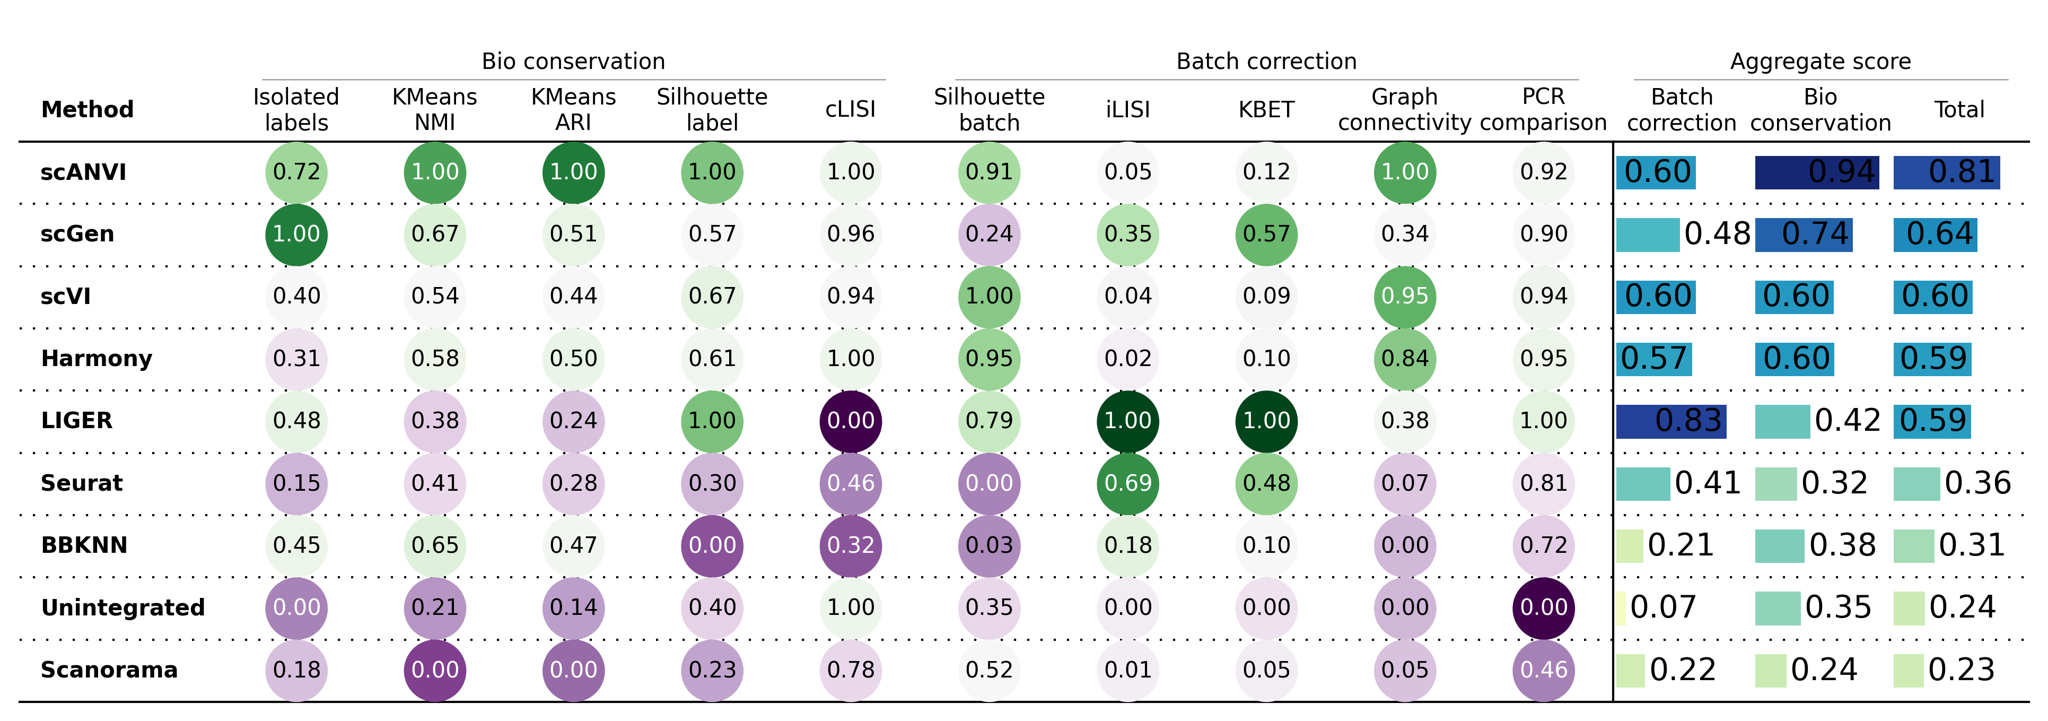

In [17]:
# scANVI is the best-performing method, particularly in preserving meaningful biological variance
bm.plot_results_table()

In [20]:
from rich import print

df = bm.get_results(min_max_scale=False)
df.transpose()

Embedding          Unintegrated Scanorama     LIGER   Harmony      scVI  \
Isolated labels        0.560055  0.585614  0.627888  0.603754  0.616515   
KMeans NMI             0.494611  0.451431  0.530301  0.573044  0.563472   
KMeans ARI             0.283803  0.245711  0.312459   0.38437  0.368033   
Silhouette label       0.516668  0.505307  0.556681    0.5307  0.534674   
cLISI                       1.0  0.998606  0.993698       1.0  0.999638   
Silhouette batch        0.74083  0.779257  0.838152  0.874512  0.885585   
iLISI                       0.0  0.001415  0.226893  0.003616   0.00917   
KBET                   0.001141  0.015668  0.280414  0.028363   0.02634   
Graph connectivity     0.735671  0.745244  0.811831  0.905838   0.92744   
PCR comparison              0.0  0.436186  0.946659  0.902536  0.886177   
Batch correction       0.295528  0.395554   0.62079  0.542973  0.546942   
Bio conservation       0.571028  0.557334  0.604205  0.618374  0.616466   
Total                  0.460828  0.492622  0.610839  0.588213  0.588657   

Embedding             Seurat    scANVI     BBKNN     scGen       Metric Type  
Isolated labels     0.581187  0.661473  0.623269  0.700284  Bio conservation  
KMeans NMI          0.537666  0.660697  0.587265  0.591654  Bio conservation  
KMeans ARI           0.32242  0.523888  0.375258  0.386596  Bio conservation  
Silhouette label    0.509964  0.556469  0.489895   0.52813  Bio conservation  
cLISI               0.996593       1.0  0.995727  0.999732  Bio conservation  
Silhouette batch    0.661803  0.866257  0.668663  0.716269  Batch correction  
iLISI               0.156995  0.012135  0.040292  0.080191  Batch correction  
KBET                0.133886  0.034265  0.029264  0.160677  Batch correction  
Graph connectivity  0.750538  0.937147  0.736286  0.803784  Batch correction  
PCR comparison      0.763296  0.868859  0.677418  0.848759  Batch correction  
Batch correction    0.493303  0.543733  0.430384  0.521936   Aggregate score  
Bio conservation    0.589566  0.680505  0.614283  0.641279   Aggregate score  
Total               0.551061  0.625796  0.540724  0.593542   Aggregate score

In [24]:
label_key = 'celltypist_cell_label_kundaje'
batch_key = 'Batch'

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plo

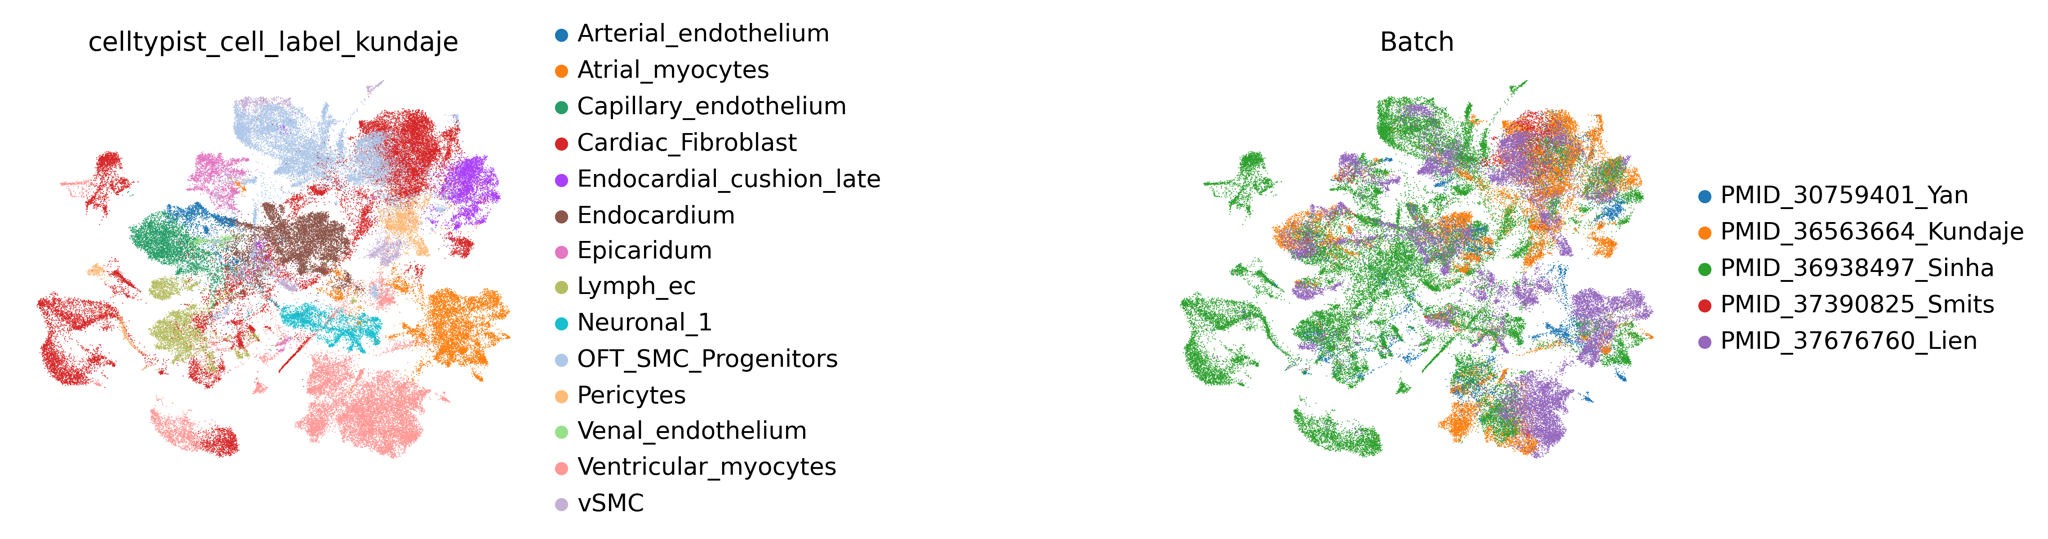

In [25]:
sc.pp.neighbors(adata, use_rep="scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=[label_key, batch_key], wspace=1)

In [31]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


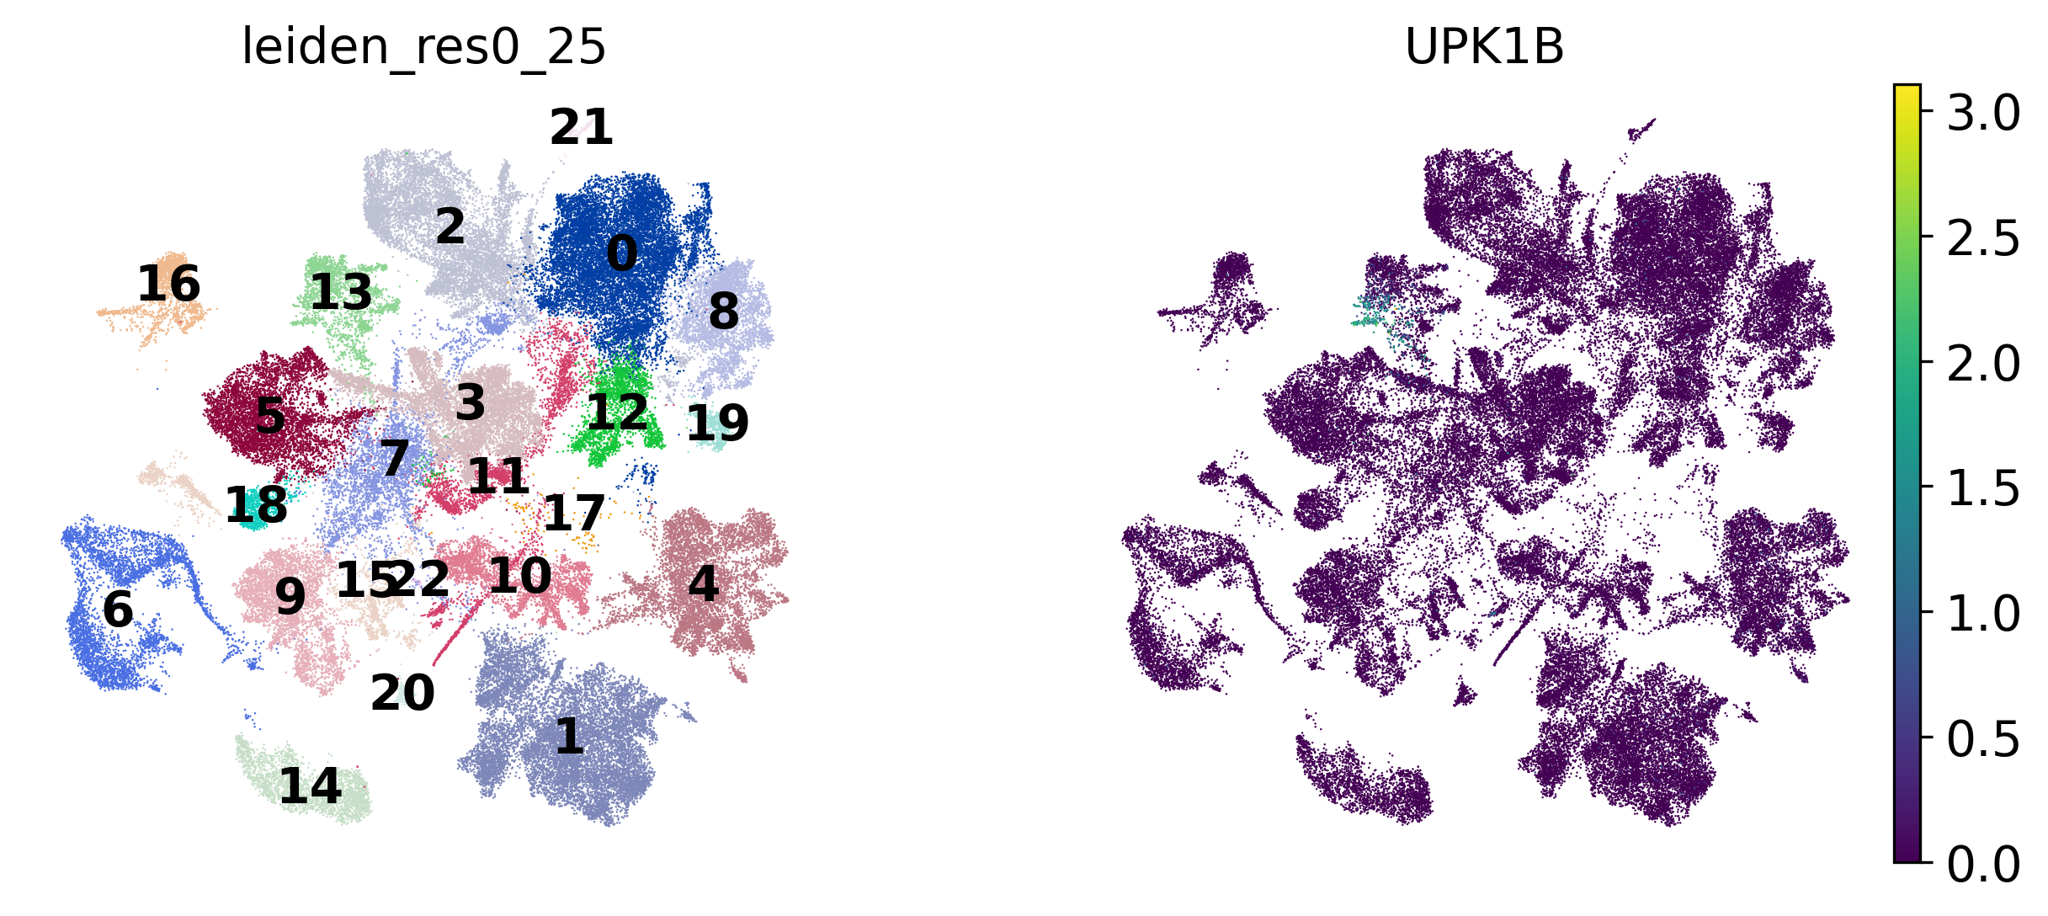

In [48]:
sc.pl.umap(adata, color=['leiden_res0_25','UPK1B'],layer='log1p_norm', legend_loc='on data')

In [34]:
# Remove doublets
adata = adata[-adata.obs['scDblFinder_class'].isin(['doublet'])]
adata

View of AnnData object with n_obs × n_vars = 84779 × 6000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Batch_colors', 'celltypist_cell_label_kundaje_colors', 'neighbors', 'pca', 'umap', 'scDblFinder_class_colors', 'leiden', 'leiden_res0_25_colors'
    obsm: 'BBKNN', 'Scanorama', 'Seurat', 'X_pca', 'X_umap', '

In [36]:
# Subset the epicardial cluster (one that highly express UPK3B)
adata_epi = adata[adata.obs['leiden_res0_25'].isin(['13'])]
adata_epi

View of AnnData object with n_obs × n_vars = 2205 × 6000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Batch_colors', 'celltypist_cell_label_kundaje_colors', 'neighbors', 'pca', 'umap', 'scDblFinder_class_colors', 'leiden', 'leiden_res0_25_colors'
    obsm: 'BBKNN', 'Scanorama', 'Seurat', 'X_pca', 'X_umap', 's